In [2]:
###INSTALLS#####################
!pip install scipy
!pip install aeon
!pip install dtaidistance
###IMPORTS######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import os, math
import pickle
from google.colab import drive
from scipy.integrate import simpson
from scipy.fft import fft, fftfreq
from scipy.signal import savgol_filter, find_peaks
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from aeon.classification.deep_learning import ResNetClassifier
from aeon.datasets import load_unit_test
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from dtaidistance import dtw
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances_argmin_min
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from torch.utils.data import TensorDataset, DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.5 MB/s eta 0:00:00


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
################## Load Data #############################
def create_df(file_path, label):
  class_names = ["eric_samples", "ashley_samples", "frida_samples"]
  classes = ["eric", "ashley", "frida"]

  acc_mag = []
  x_acc = []
  y_acc = []
  z_acc = []
  time = []

  for class_idx, class_name in enumerate(classes):
      folder_name=class_names[class_idx]
      folder_path=os.path.join(data_path,folder_name)
      for i in range(1, 6):  # Iterations 1-5
          file_path = os.path.join(folder_path, f"{class_name}_{i}.csv")

          # Load CSV file
          data = pd.read_csv(file_path) # Convert to NumPy array
          time.append(np.array(data[data.columns[0]]))
          x_acc.append(np.array(data[data.columns[1]]))
          y_acc.append(np.array(data[data.columns[2]]))
          z_acc.append(np.array(data[data.columns[3]]))
          acc_mag.append(np.array(data[data.columns[4]]))

  labels = [label] * len(acc_mag)

  #put stairs_ts_data and stair_labels into DataFrame
  return_df = pd.DataFrame({"Time": time,
                          "acc_mag": acc_mag,
                          "x_acc": x_acc,
                          "y_acc": y_acc,
                          "z_acc": z_acc,
                          "label": labels})
  return return_df

In [5]:
#function takes in dataframe and trims to 10-15s for all features
def trim_df(df):
  trimmed_df = df.copy()
  trimmed_df["Time"] = trimmed_df["Time"].apply(lambda x: x[500:1500])
  trimmed_df["acc_mag"] = trimmed_df["acc_mag"].apply(lambda x: x[500:1500])
  trimmed_df["x_acc"] = trimmed_df["x_acc"].apply(lambda x: x[500:1500])
  trimmed_df["y_acc"] = trimmed_df["y_acc"].apply(lambda x: x[500:1500])
  trimmed_df["z_acc"] = trimmed_df["z_acc"].apply(lambda x: x[500:1500])
  return trimmed_df

In [6]:
#function to return tensor from dataframe
def df_to_tensor(df):
  df_cols = df.columns
  # Stack into a torch tensor
  tensor_data = torch.tensor(np.stack([np.stack([df[col].iloc[i] for col in df]) for i in range(len(df))]), dtype=torch.float32)

  return tensor_data



In [7]:
#Max-Min Normalization
def apply_max_min_normalization(data, epsilon=1e-8):
    min_values = torch.min(data, dim=2, keepdim=True).values
    max_values = torch.max(data, dim=2, keepdim=True).values
    normalized_data = (data - min_values) / (max_values - min_values + epsilon)
    return normalized_data

In [8]:
#Z-Score Normalization
def apply_zscore_normalization(data, epsilon=1e-8):
    mean = torch.mean(data, dim=2, keepdim=True)
    std = torch.std(data, dim=2, keepdim=True)
    normalized_data = (data - mean) / (std + epsilon)
    return normalized_data

In [9]:
#function for data augmentation-->zero out random interval
def insert_random_zero_block(data_tensor, block_size=200):
    """
    Insert a block of zeros at a random location within each sample in the tensor.

    Parameters:
    - data_tensor: torch.Tensor of shape [30, num_channels, 1000]
    - block_size: int, number of consecutive zeros to insert (default=200)

    Returns:
    - augmented_tensor: torch.Tensor of same shape with inserted zero blocks
    """
    #assert data_tensor.shape[0] ==30, "Expected 30 samples"
    #assert data_tensor.shape[2] >= block_size, "Time length must be >= block size"

    augmented_tensor = data_tensor.clone()  # Avoid modifying original tensor
    num_samples, num_channels, time_length = data_tensor.shape

    for i in range(num_samples):
        # start = random.randint(0, time_length - block_size)
        start = np.random.randint(0, time_length - block_size + 1)
        augmented_tensor[i, :, start:start + block_size] = 0.0

    return augmented_tensor

In [10]:
def apply_noise(data, noise_std=0.05):
  noise = torch.randn_like(data) * noise_std
  noisy_data = data + noise
  return noisy_data

In [11]:
def create_conf_matrix(y_test,y_pred):
  confusion_matrix(y_test,y_pred)

  #create plot from confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [12]:
#function for plotting t-SNE
def plot_tSNE(data, y_lbls, title):
    #plot t-SNE results for acc-mag
    plt.figure(figsize=(10, 6))
    #class labels
    classes = [0, 1]
    colors = ['red', 'blue']
    #plot t-SNE results
    for cls, color in zip(classes, colors):
        if cls == 0:
          cls_ = "stairs"
        else:
          cls_ = "walking"
        idx = np.where(y_lbls == cls)
        plt.scatter(data[idx, 0], data[idx, 1], c=color, label=f"Class: {cls_}")
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.title(f"t-SNE for {title}")
    plt.grid(True)
    plt.show()

In [13]:
import matplotlib.pyplot as plt

def plot_aug_tSNE(X_tsne, class_labels, is_augmented, title="t-SNE Plot"):
    plt.figure(figsize=(10, 6))
    for i in range(len(X_tsne)):
        color = 'red' if class_labels[i] == 0 else 'blue'  # stairs vs walking
        marker = 'x' if is_augmented[i] == 1 else 'o'      # augmented vs original
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1], c=color, marker=marker, label=None, alpha=0.8)

    # Create custom legends
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Original Sample', markerfacecolor='gray', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Augmented Sample', markerfacecolor='black', markersize=8),
        Line2D([0], [0], marker='o', color='red', label='Class: stairs', linestyle='None'),
        Line2D([0], [0], marker='o', color='blue', label='Class: walking', linestyle='None')
    ]
    plt.legend(handles=legend_elements)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()


In [14]:
#########STAIRS DATA#############################

In [15]:
#create stairs df
data_path  = "/content/drive/MyDrive/8361_TimeSeries_project/data/stairs"
label = data_path.split("/")[-1]
print(label)
stairs_df = create_df(data_path, label=label)
print(stairs_df.shape)
stairs_df.head()

stairs
(15, 6)


,Time,acc_mag,x_acc,y_acc,z_acc,label
0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[2.3, 1.3, 0.67, 0.49, 0.68, 0.96, 0.91, 0.65,...","[-0.15, -0.5, -0.22, 0.08, 0.08, 0.08, 0.0, -0...","[1.27, 1.01, 0.42, -0.18, -0.67, -0.95, -0.91,...","[-1.91, -0.64, -0.47, -0.45, -0.07, 0.08, 0.01...",stairs
1,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.97, 0.9, 0.59, 0.08, 0.41, 0.82, 0.95, 0.75...","[-0.44, -0.39, -0.27, 0.0, 0.1, 0.23, 0.43, 0....","[0.86, 0.81, 0.51, -0.0, -0.37, -0.56, -0.73, ...","[0.13, -0.02, 0.12, -0.08, 0.15, 0.55, 0.44, 0...",stairs
2,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[2.53, 2.9, 2.54, 2.31, 2.1, 2.74, 2.65, 2.44,...","[-1.4, -1.4, -1.28, -1.3, -1.41, -1.66, -1.57,...","[0.35, -0.0, -0.05, 0.22, 0.85, 1.47, 1.41, 1....","[-2.07, -2.54, -2.2, -1.9, -1.31, -1.61, -1.61...",stairs
3,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.52, 3.65, 3.32, 2.74, 2.51, 2.59, 2.65, 2.2...","[2.31, 2.22, 2.52, 2.6, 2.46, 2.36, 2.33, 2.02...","[-1.18, -1.15, -0.86, -0.52, -0.14, 0.32, 0.73...","[-2.38, -2.66, -1.97, -0.69, 0.51, 1.03, 1.05,...",stairs
4,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.35, 1.8, 2.12, 2.14, 1.76, 2.08, 1.52, 1.09...","[-0.18, -0.11, 0.05, 0.06, 0.02, 0.15, 0.32, -...","[-0.73, -0.7, -0.6, -0.37, -0.34, 0.17, 0.43, ...","[-1.13, -1.65, -2.03, -2.11, -1.73, -2.07, -1....",stairs


In [16]:
#apply trim-df to stairs-df
trimmed_stairs_df = trim_df(stairs_df)
#drop time-column
stairs_lbls = np.array(trimmed_stairs_df["label"])
trimmed_stairs_df = trimmed_stairs_df.drop(columns=["Time", "label"])
print(stairs_lbls)
print(trimmed_stairs_df.shape)
trimmed_stairs_df.head()

['stairs' 'stairs' 'stairs' 'stairs' 'stairs' 'stairs' 'stairs' 'stairs'
 'stairs' 'stairs' 'stairs' 'stairs' 'stairs' 'stairs' 'stairs']
(15, 4)


,acc_mag,x_acc,y_acc,z_acc
0,"[4.79, 3.3, 3.12, 4.46, 5.59, 5.72, 5.28, 4.57...","[1.35, 1.52, 2.57, 4.04, 4.76, 4.51, 3.75, 3.0...","[4.09, 2.28, 1.2, 0.21, -0.63, -0.91, -1.13, -...","[2.09, 1.84, 1.31, 1.87, 2.87, 3.4, 3.54, 3.27..."
1,"[4.76, 4.27, 3.72, 3.21, 3.48, 3.62, 3.97, 5.8...","[-2.75, -2.23, -1.57, -1.09, -0.89, -1.05, -2....","[-1.69, -1.0, -0.28, 0.24, 0.66, 1.51, 3.04, 4...","[-3.5, -3.5, -3.36, -3.01, -3.3, -3.12, -1.04,..."
2,"[3.44, 3.89, 4.2, 4.01, 3.49, 2.72, 2.51, 3.37...","[1.35, 1.66, 1.97, 1.98, 1.47, 0.79, 0.46, 0.4...","[-1.48, -1.83, -2.12, -2.34, -2.56, -2.54, -2....","[2.8, 3.0, 3.04, 2.59, 1.85, 0.58, -0.47, -1.0..."
3,"[5.69, 6.53, 7.22, 7.59, 7.29, 7.83, 8.61, 8.1...","[2.26, 2.64, 2.8, 2.76, 2.16, 1.47, 1.87, 2.37...","[3.05, 4.4, 5.68, 6.21, 6.72, 7.62, 8.15, 7.48...","[-4.24, -4.04, -3.48, -3.39, -1.8, 0.99, 2.08,..."
4,"[3.56, 2.1, 2.12, 3.35, 4.91, 5.88, 7.56, 8.71...","[-1.95, -1.52, -1.1, -0.86, -0.59, -0.05, 0.57...","[-2.89, -1.32, 0.11, 1.75, 3.38, 4.05, 4.94, 6...","[0.68, -0.58, -1.81, -2.72, -3.5, -4.25, -5.69..."


In [17]:
#create stairs tensor
stairs_tensor = df_to_tensor(trimmed_stairs_df)
stairs_tensor.shape

torch.Size([15, 4, 1000])

In [18]:
#########WALKING DATA#############################

In [19]:
#create walking df
data_path  = "/content/drive/MyDrive/8361_TimeSeries_project/data/walking"
label = data_path.split("/")[-1]
print(label)
walking_df = create_df(data_path, label=label)
print(walking_df.shape)
walking_df.head()

walking
(15, 6)


,Time,acc_mag,x_acc,y_acc,z_acc,label
0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.33, 0.27, 0.65, 0.65, 0.7, 0.82, 0.88, 0.85...","[-0.02, 0.22, 0.41, 0.33, 0.25, 0.3, 0.38, 0.3...","[-0.3, 0.12, 0.45, 0.49, 0.4, 0.52, 0.67, 0.69...","[-0.12, -0.1, -0.23, 0.26, 0.52, 0.57, 0.41, 0...",walking
1,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.04, 0.76, 0.53, 0.48, 0.58, 0.8, 1.01, 1.06...","[-0.21, 0.0, 0.26, 0.44, 0.51, 0.46, 0.29, -0....","[0.01, 0.27, 0.28, 0.04, -0.04, -0.02, -0.12, ...","[-1.02, -0.71, -0.37, -0.19, 0.25, 0.66, 0.96,...",walking
2,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.08, 0.93, 0.77, 1.08, 1.73, 2.68, 3.16, 2.9...","[0.52, 0.33, -0.06, -0.49, -1.13, -2.05, -2.36...","[-0.09, -0.49, -0.65, -0.96, -1.27, -1.58, -1....","[0.94, 0.71, 0.41, -0.03, -0.3, -0.7, -1.58, -...",walking
3,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.05, 0.78, 0.95, 1.37, 1.65, 2.68, 3.08, 1.0...","[0.29, 0.12, 0.05, 0.73, 0.62, -0.4, -0.91, -0...","[-1.0, -0.77, -0.86, -0.71, -0.42, -0.46, -1.2...","[0.12, -0.01, -0.41, -0.91, -1.47, -2.61, -2.6...",walking
4,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.51, 2.85, 3.58, 3.57, 3.19, 2.15, 0.67, 1.5...","[-0.7, -0.48, 0.79, 0.74, 0.17, 0.35, 0.64, 0....","[0.12, 0.39, 0.22, 0.53, 1.0, 0.75, 0.1, -0.07...","[-1.33, -2.78, -3.49, -3.46, -3.03, -1.98, -0....",walking


In [20]:
#apply trim-df to walking-df
trimmed_walking_df = trim_df(walking_df)
#drop time-column
walking_lbls = np.array(trimmed_walking_df["label"])
trimmed_walking_df = trimmed_walking_df.drop(columns=["Time", "label"])
print(walking_lbls)
print(trimmed_walking_df.shape)
trimmed_walking_df.head()

['walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking' 'walking' 'walking' 'walking' 'walking' 'walking' 'walking'
 'walking']
(15, 4)


,acc_mag,x_acc,y_acc,z_acc
0,"[5.53, 6.29, 6.49, 6.33, 6.1, 4.75, 3.37, 2.3,...","[1.36, 1.09, 1.46, 2.27, 2.27, 1.64, 1.11, 0.2...","[1.34, -0.83, -2.73, -3.73, -3.93, -3.2, -2.19...","[5.18, 6.14, 5.71, 4.59, 4.06, 3.1, 2.31, 1.62..."
1,"[8.1, 9.66, 10.39, 8.73, 6.14, 4.89, 4.51, 3.7...","[-1.88, -2.06, -2.06, -1.97, -1.92, -1.72, -1....","[6.83, 8.06, 9.07, 8.05, 5.71, 4.16, 3.68, 3.2...","[3.93, 4.91, 4.62, 2.72, 1.18, 1.89, 2.37, 1.6..."
2,"[4.79, 4.42, 3.87, 3.2, 2.43, 2.06, 2.9, 5.08,...","[-3.43, -3.22, -2.65, -1.83, -0.79, 0.4, 1.78,...","[-1.85, -1.99, -2.19, -2.31, -2.23, -2.0, -1.7...","[2.79, 2.28, 1.77, 1.26, 0.52, -0.33, -1.43, -..."
3,"[2.3, 2.36, 2.54, 2.86, 3.11, 3.23, 3.34, 3.76...","[1.65, 1.58, 1.63, 1.76, 1.85, 1.72, 1.36, 0.9...","[-1.3, -1.41, -1.4, -1.52, -1.6, -1.65, -1.83,...","[-0.93, -1.05, -1.34, -1.66, -1.91, -2.17, -2...."
4,"[1.81, 2.19, 2.42, 2.45, 2.36, 2.17, 1.89, 1.5...","[1.26, 1.87, 2.21, 2.28, 2.19, 2.01, 1.76, 1.4...","[-1.1, -0.98, -0.91, -0.91, -0.88, -0.8, -0.7,...","[-0.67, -0.59, -0.34, -0.08, 0.06, 0.07, -0.06..."


In [21]:
#create walking tensor
walking_tensor = df_to_tensor(trimmed_walking_df)
walking_tensor.shape

torch.Size([15, 4, 1000])

In [22]:
#########creating Data Tensor and Labels#################

In [23]:
#concatenate stairs tensor and walking tensor
X = torch.cat((stairs_tensor, walking_tensor), dim=0)
print(X.shape)

#concatenate stairs labels and walking labels
y = np.concatenate((stairs_lbls, walking_lbls))
print(y.shape)

torch.Size([30, 4, 1000])
(30,)


In [24]:
#convert y-labels from strings to ints
y_dict = {"stairs": 0, "walking": 1}
y_lbls = np.array([y_dict[label] for label in y])
print(y_lbls)
print(y.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(30,)


In [25]:
#Normalize Data
X_norm = apply_max_min_normalization(X)
print(X_norm.shape)

torch.Size([30, 4, 1000])


#Apply the TSNE plot

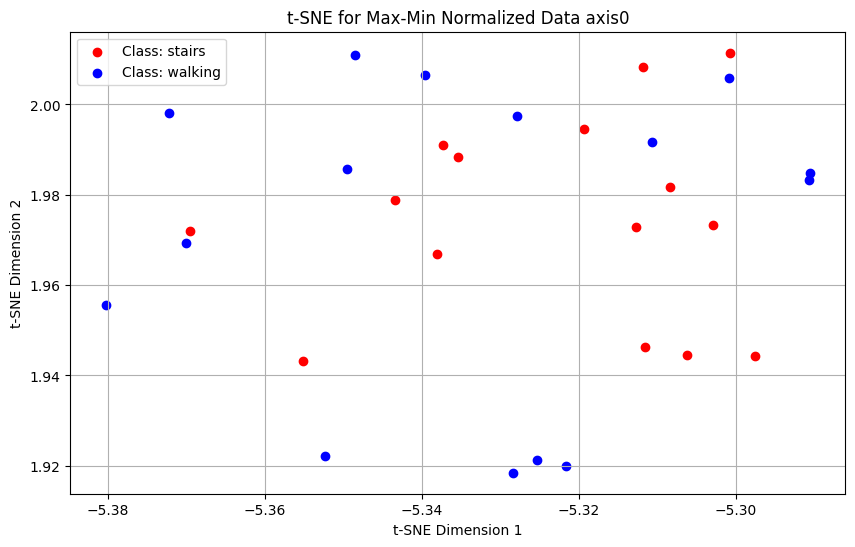

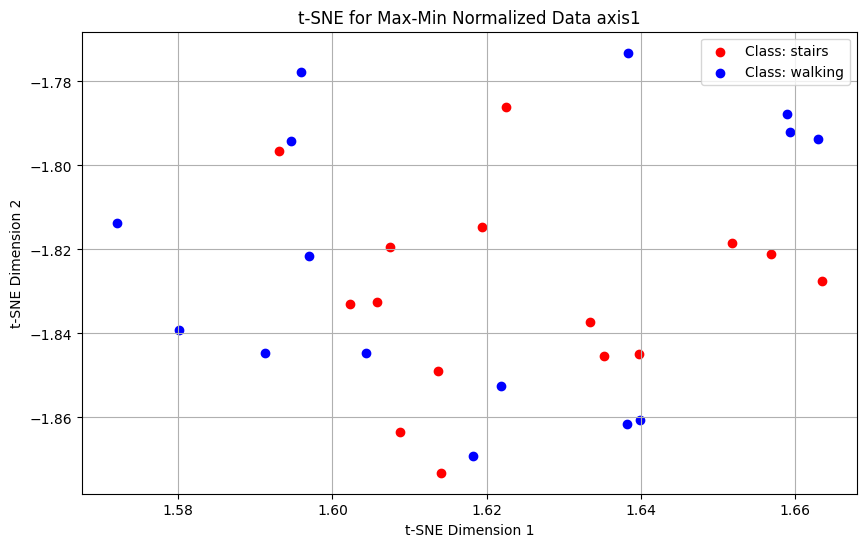

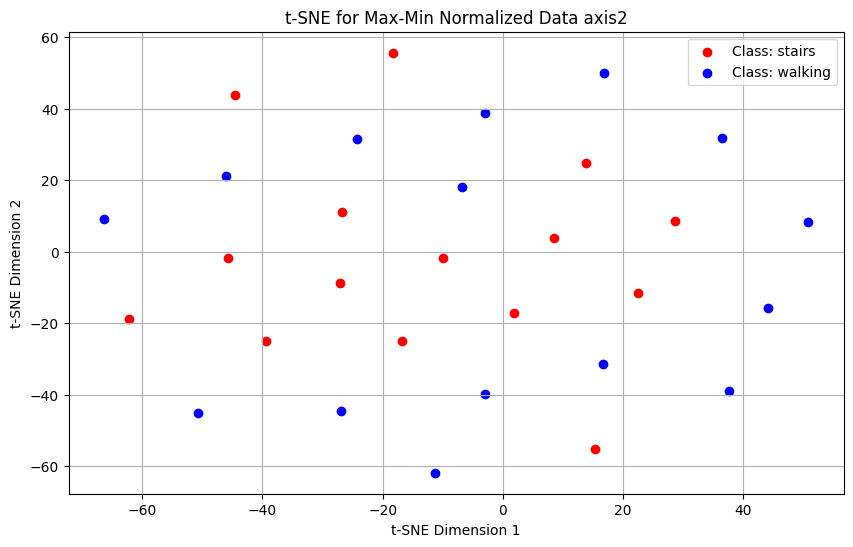

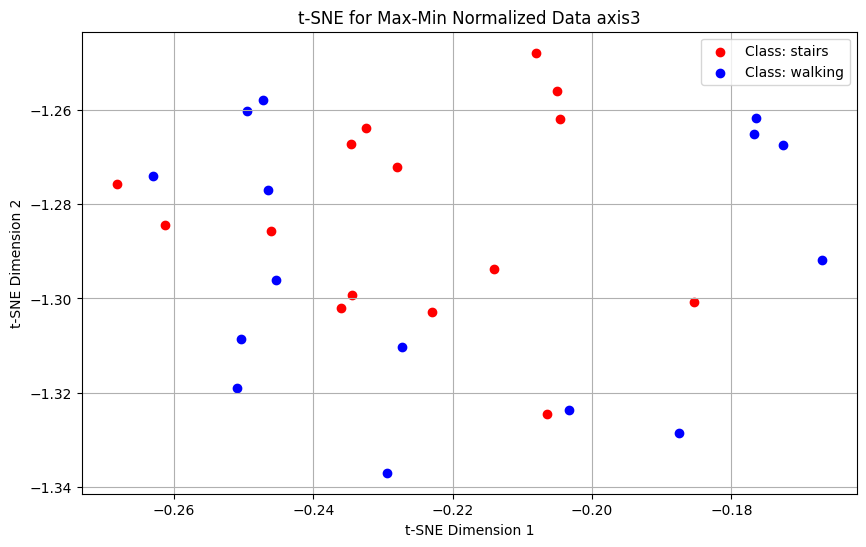

In [67]:
# prompt: tsne plot of class 1 and class 0
for i in range(0,4):
  from sklearn.manifold import TSNE
  X_plot=X_norm[:,:,:]
  # Reshape the data for t-SNE (flatten the time series and channels)
  X_flat = X_plot.view(X_plot.shape[0], -1).numpy()
  # Apply t-SNE
  tsne = TSNE(n_components=2,perplexity=29)
  X_tsne = tsne.fit_transform(X_flat)
  # Plot the results
  plot_tSNE(X_tsne, y_lbls, f"Max-Min Normalized Data axis{i}")

In [27]:
#create train-test split on normalized data
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(X_norm, y_lbls, test_size=0.3, random_state=42)

print(X_train_norm.shape)
print(X_test_norm.shape)
print(Y_train_norm.shape)
print(Y_test_norm.shape)

torch.Size([21, 4, 1000])
torch.Size([9, 4, 1000])
(21,)
(9,)


## Step 1: Train Rocket Classifier on training data


Accuracy: 88.88888888888889%


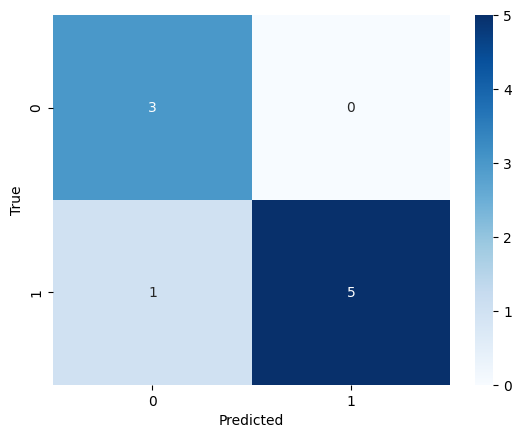

In [28]:
#Use Rocket classifier on Normalized Dataset
rocket_clfr = RocketClassifier(n_kernels=2000)
rocket_clfr.fit(X_train_norm.numpy(), Y_train_norm)
y_pred_rkt_norm = rocket_clfr.predict(X_test_norm.numpy())
accuracy_rkt_norm = accuracy_score(Y_test_norm, y_pred_rkt_norm)
print("Accuracy: {}%".format(accuracy_rkt_norm * 100))

#create confusion matrix
create_conf_matrix(Y_test_norm, y_pred_rkt_norm)

In [29]:
#save parameters '.pth' for Rocket classifier
'''
with open('/content/drive/MyDrive/8361_TimeSeries_project/wonder_model.pkl', 'wb') as f:
     pickle.dump(rocket_clfr, f)

'''

"\nwith open('/content/drive/MyDrive/8361_TimeSeries_project/wonder_model.pkl', 'wb') as f:\n     pickle.dump(rocket_clfr, f)\n\n"

# Apply the PSA


# Step 2: Explain model's decision on testing data

3
random-instance lbl: 1
random-instance pred: 1
torch.Size([1, 4, 1000])


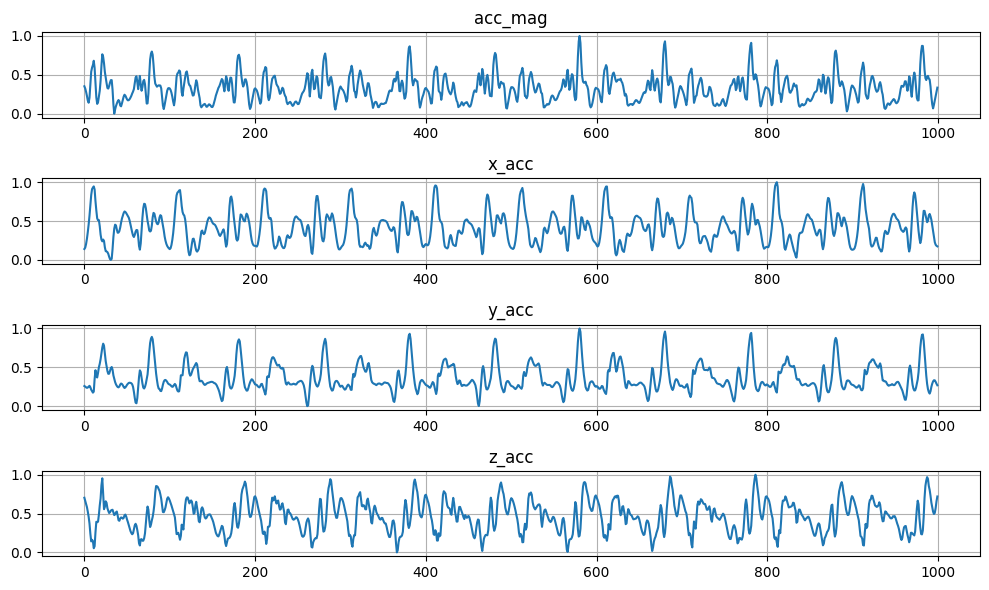

In [ ]:
#pick a random instance from testset
random_idx = np.random.randint(0, len(X_test_norm))
print(random_idx)
y_sample_lbl = Y_test_norm[random_idx]
print("random-instance lbl: {}".format(y_sample_lbl))
print("random-instance pred: {}".format(y_pred_rkt_norm[random_idx]))

X_test_norm_sample = X_test_norm[random_idx].unsqueeze(0)
print(X_test_norm_sample.shape)
cols = trimmed_stairs_df.columns

#plot random instance as subplots
plt.figure(figsize=(10, 6))
for i in range(X_test_norm_sample.shape[1]):
    plt.subplot(4, 1, i + 1)
    plt.plot(X_test_norm_sample[0, i, :])
    plt.title(cols[i])
    plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Parameters
num_to_augment = 20
noise_std = 0.05  # standard deviation for Gaussian noise

# Augmentation function
def augment_sample(sample, noise_std=0.05):
    aug_samp = insert_random_zero_block(sample.unsqueeze(0))
    aug_samp_noised = apply_noise(aug_samp, noise_std).squeeze(0)
    return aug_samp_noised  # should return shape: [dim, time]

# Randomly select 20 unique indices
indices = np.random.choice(len(X_norm), size=num_to_augment, replace=False)

# Apply augmentation to each selected sample
X_augmented = []
y_augmented = []

for idx in indices:
    sample = X_norm[idx]  # shape: [dim, time]
    label = y_lbls[idx]

    augmented = augment_sample(sample, noise_std)  # shape: [dim, time]
    X_augmented.append(augmented[np.newaxis, ...])  # shape becomes [1, dim, time]
    y_augmented.append(label)

# Convert to arrays
X_augmented = np.concatenate(X_augmented, axis=0)  # shape: [num_to_augment, dim, time]
y_augmented = np.array(y_augmented)

print(f"Augmented {X_augmented.shape[0]} samples of shape {X_augmented.shape[1:]} each.")

Augmented 20 samples of shape (4, 1000) each.


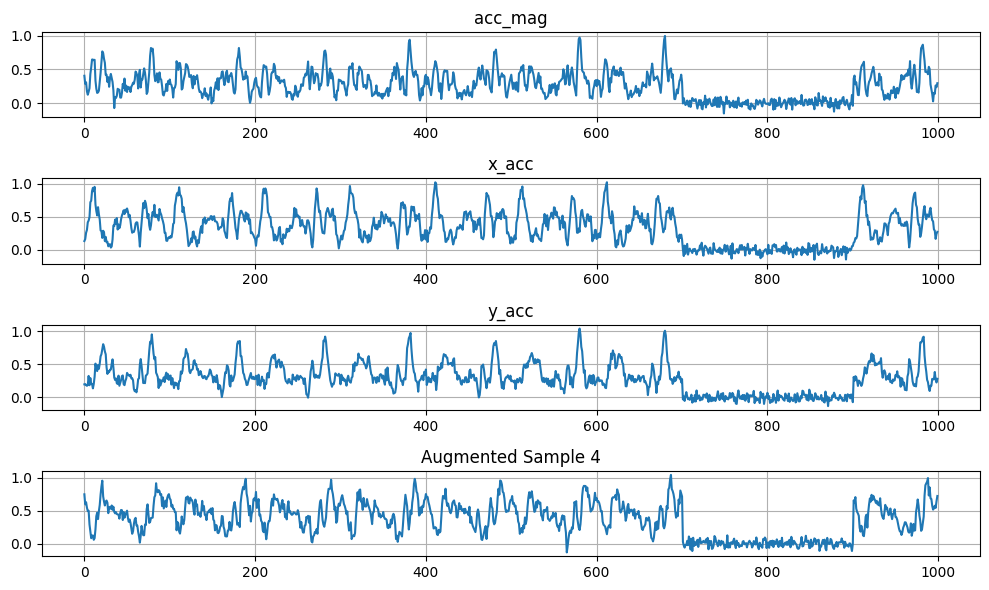

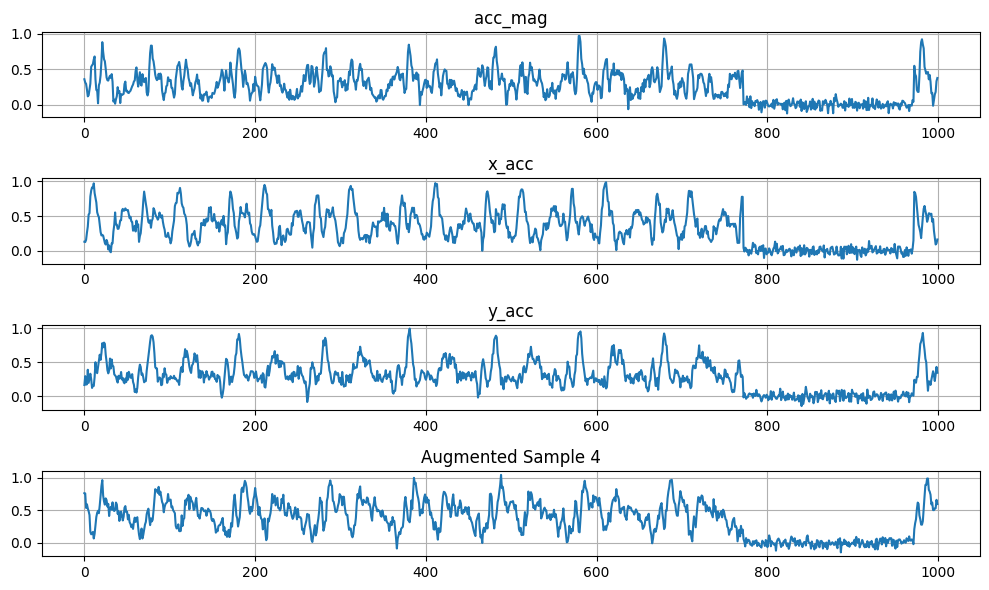

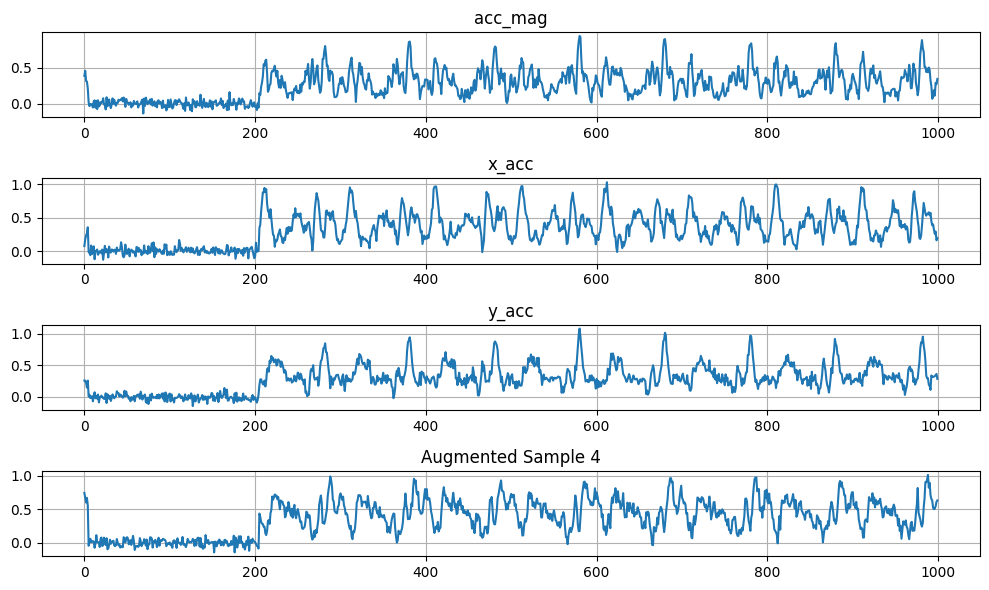

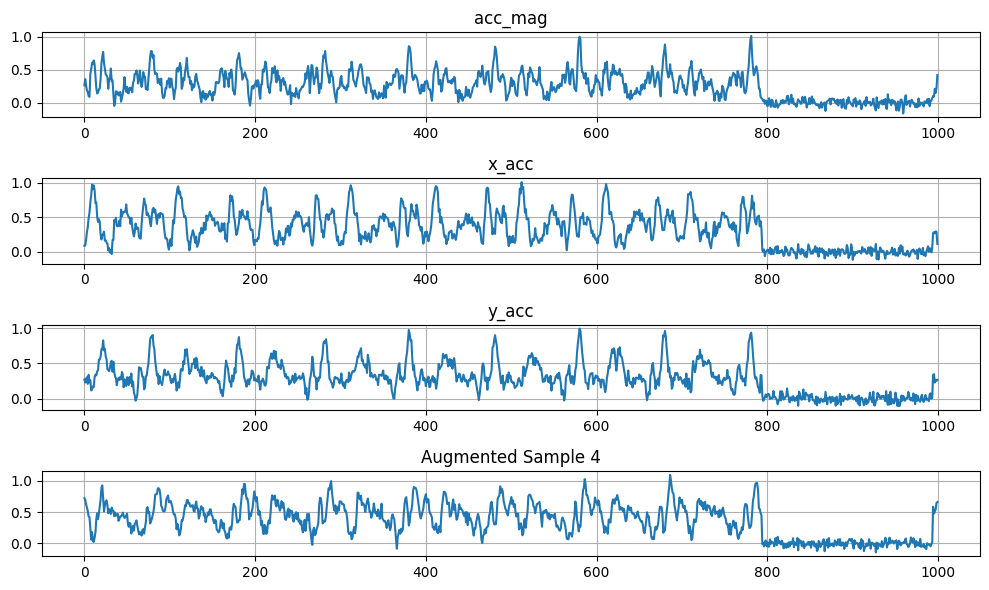

In [ ]:
#collect 20 augmented time-series isntance from random-instance
augmented_samples = []
for i in range(20):
  aug_samp = insert_random_zero_block(X_test_norm_sample)
  aug_samp_noised = apply_noise(aug_samp)
  augmented_samples.append(aug_samp_noised)

#show subplots for augmented samples
for i, aug_samp in enumerate(augmented_samples):
    if i % 5 == 0:
        plt.figure(figsize=(10, 6))
        for i in range(aug_samp.shape[1]):
            plt.subplot(4, 1, i + 1)
            plt.plot(aug_samp[0, i, :])
            plt.title(cols[i])
            plt.grid()
        plt.title(f"Augmented Sample {i+1}")
        plt.tight_layout()
        plt.show()


In [ ]:
#go thrugh augmented samples and insert into dataframe
augmented_samples_df = pd.DataFrame(columns=cols)
for i in range(len(augmented_samples)):
  aug_samp = augmented_samples[i]
  for j in range(aug_samp.shape[1]):
    # print("J: {}".format(j))
    # print(aug_samp[0, j, :])
    augmented_samples_df.loc[i, cols[j]] = aug_samp[0, j, :]

print(augmented_samples_df.shape)
augmented_samples_df.head()

#df to tensor
augmented_samples_tensor = df_to_tensor(augmented_samples_df)
print(augmented_samples_tensor.shape)


(20, 4)
torch.Size([20, 4, 1000])


In [ ]:
########TSNE plots for Augmented Min-Max normalization###################

torch.Size([20, 4, 1000])
(20, 2)


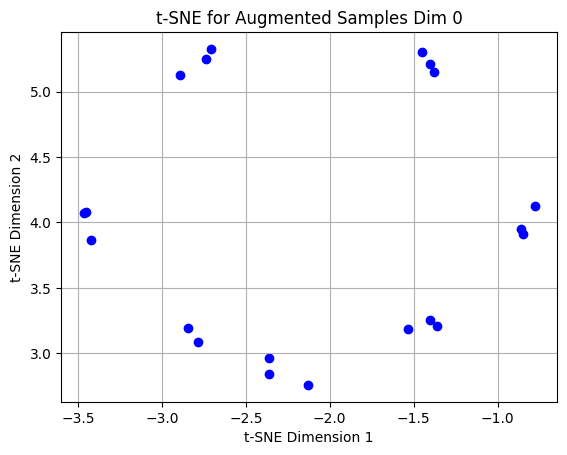

(20, 2)


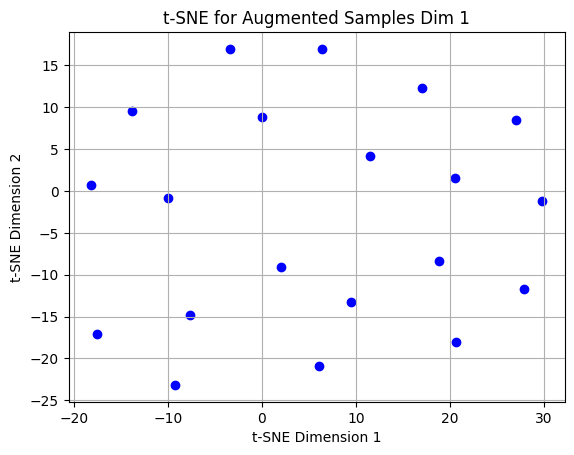

(20, 2)


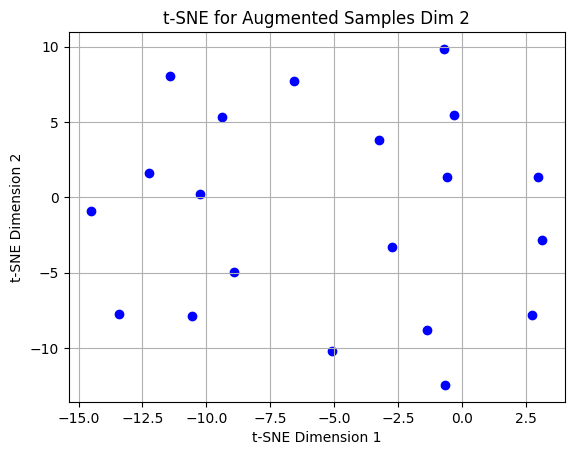

(20, 2)


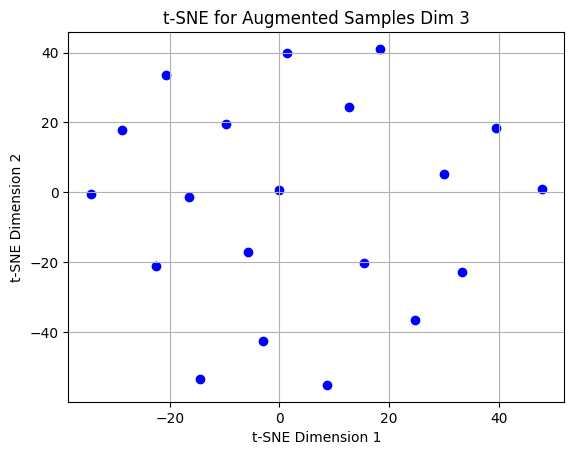

In [ ]:
#collect Augmented X-normed Acc. Magnitude
X_norm_acc_mag = augmented_samples_tensor[:, :, :]
print(X_norm_acc_mag.shape)
#Apply t-SNE to acc-mag
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
for j in range(X_norm_acc_mag.shape[1]):
  X_norm_tsne_accmag = tsne.fit_transform(X_norm_acc_mag[:,j,:])
  print(X_norm_tsne_accmag.shape)

  #plot tSNE for Acc. Maag.
  for i in range(X_norm_tsne_accmag.shape[0]):
    plt.scatter(X_norm_tsne_accmag[i, 0], X_norm_tsne_accmag[i, 1], color='blue')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.title(f't-SNE for Augmented Samples Dim {j}',)
  plt.grid(True)
  plt.show()

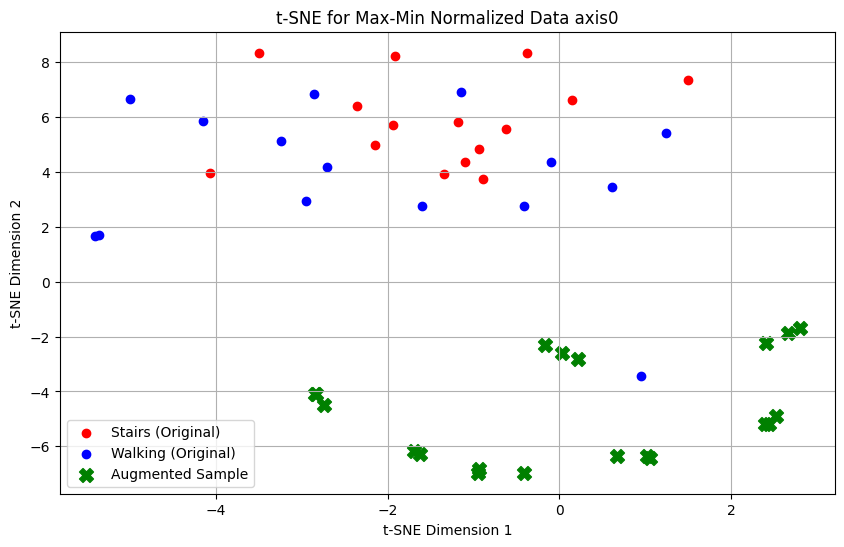

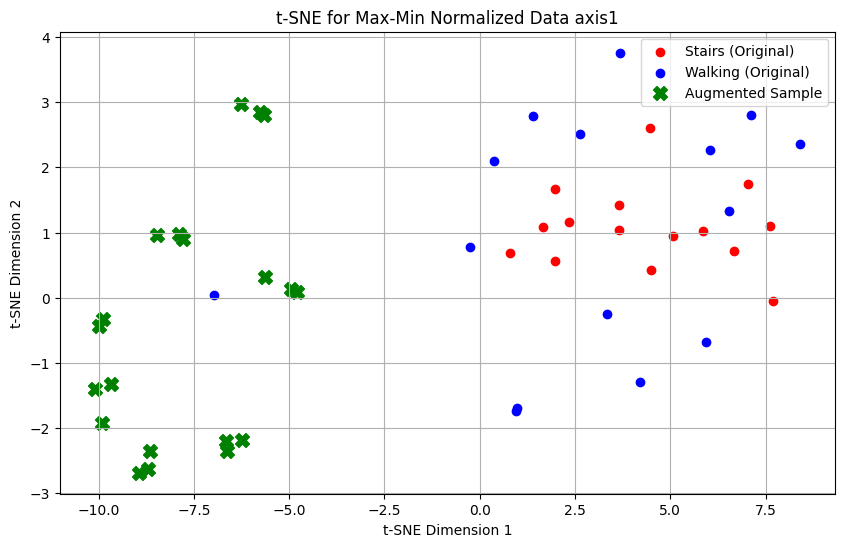

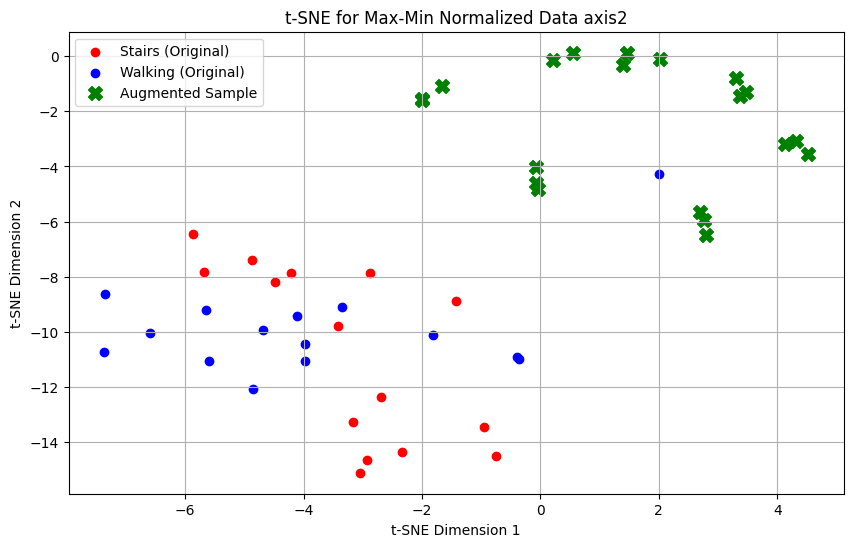

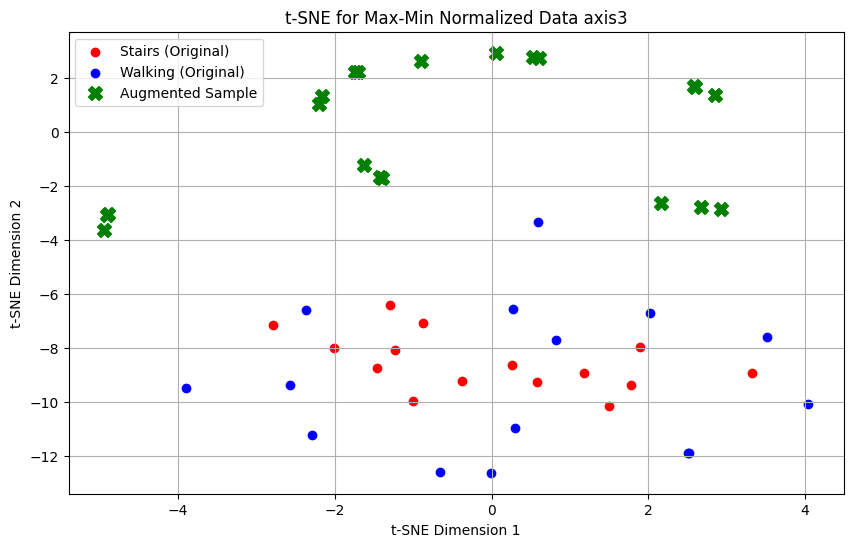

In [ ]:
# prompt: tsne plot of class 1 and class 0
for i in range(0,4):
  from sklearn.manifold import TSNE
  plotting_labels = np.concatenate((y_lbls, np.full(len(augmented_samples_tensor), 2)), axis=0)
  X_plot=torch.cat((X_norm[:,i,:],augmented_samples_tensor[:,i,:]), dim=0)
  # Reshape the data for t-SNE (flatten the time series and channels)
  X_flat = X_plot.view(X_plot.shape[0], -1).numpy()
  # Apply t-SNE
  tsne = TSNE(n_components=2, random_state=42,perplexity =14)
  X_tsne = tsne.fit_transform(X_flat)
  # Plot the results
  plot_aug_tSNE(X_tsne, plotting_labels, f"Max-Min Normalized Data axis{i}")

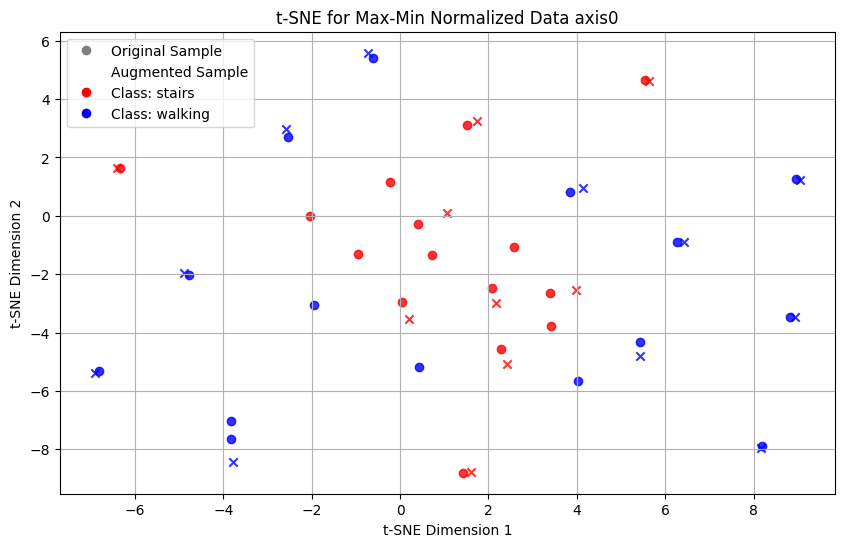

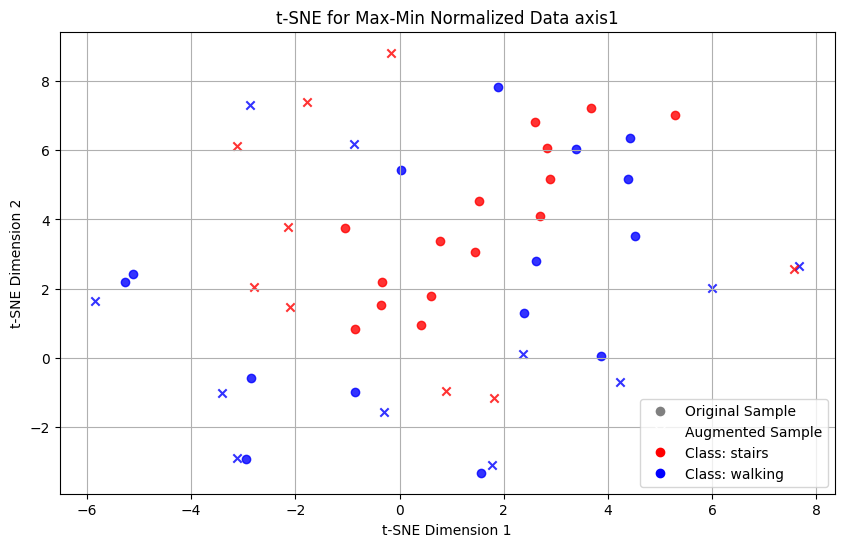

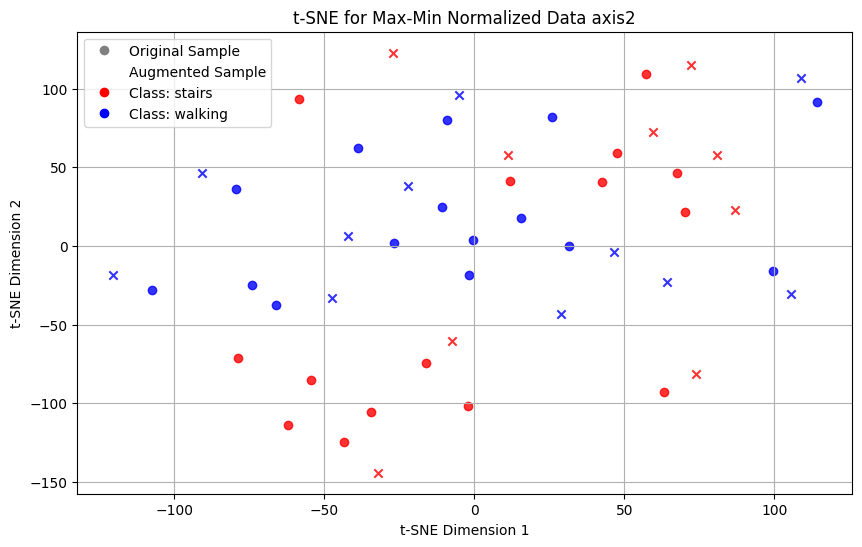

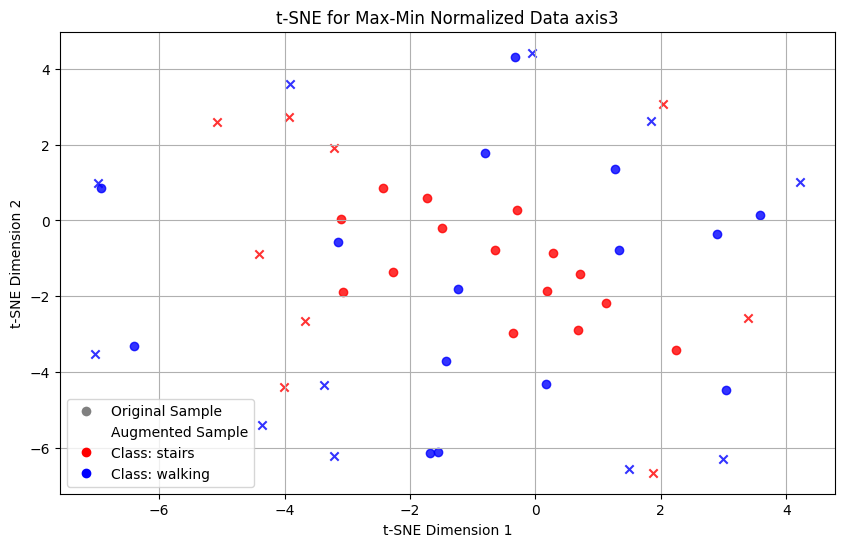

In [ ]:
from sklearn.manifold import TSNE
import torch
import numpy as np

for i in range(0, 4):
    # Concatenate along batch dimension
    X_plot = torch.cat((X_norm[:, i, :], torch.from_numpy(X_augmented[:, i, :])), dim=0)

    # Create marker labels: 0 for original, 1 for augmented
    is_augmented = np.array([0] * len(y_lbls) + [1] * len(y_augmented))  # Used for marker type
    class_labels = np.concatenate((y_lbls, y_augmented), axis=0)         # Used for color

    # Flatten for t-SNE
    X_flat = X_plot.view(X_plot.shape[0], -1).numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=14)
    X_tsne = tsne.fit_transform(X_flat)

    # Plot with custom function
    plot_aug_tSNE(X_tsne, class_labels, is_augmented, title=f"t-SNE for Max-Min Normalized Data axis{i}")


# Step 3: Load model-parameters and get prediction with augmented samples

In [ ]:
#Load pickle parameters from Rocket classifier
with open('/content/drive/MyDrive/8361_TimeSeries_project/wonder_model.pkl', 'rb') as f:
    rocket_clfr = pickle.load(f)

#get ground truth class list from y-sample-lbl
y_sample_lbl_list = [y_sample_lbl] * augmented_samples_tensor.shape[0]
print(y_sample_lbl_list)

[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


In [ ]:
#go through augmented samples tensor and classify samples
predictions = []

for i in range(augmented_samples_tensor.shape[0]):
  aug_samp = augmented_samples_tensor[i, :, :].unsqueeze(0)
  y_pred_rkt = rocket_clfr.predict(aug_samp.numpy())
  predictions.append(y_pred_rkt[0])

print(predictions)

augmented_accuracy = accuracy_score(y_sample_lbl_list, predictions)
print("Accuracy: {}%".format(augmented_accuracy * 100))




[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Accuracy: 100.0%






# Step 4: SAX

In [ ]:
#import Lab 6 Journal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%run /content/drive/MyDrive/8361_TimeSeries_project/Lab6_DTW_and_SAX+BOP.ipynb

FileNotFoundError: [Errno 2] No such file or directory: 'X_norm.pt'

FileNotFoundError: [Errno 2] No such file or directory: 'X_norm.pt'

In [ ]:
# y_sample_lbl_list to numpy array
list_to_array = np.array(y_sample_lbl_list)
print(list_to_array.shape)
print(augmented_samples_tensor.shape)

In [ ]:
print(X_train_norm.shape)
print(Y_train_norm.shape)

In [ ]:
# A is alphabet size

In [ ]:
# rocket_clfr.fit(X_train_norm.numpy(), Y_train_norm)
# X_test=aug_samp.numpy() and y_test=y_sample_lbl_list

best_score, best_params = get_best_combination(X_train_norm, Y_train_norm, augmented_samples_tensor,list_to_array)
print("Best Score:", best_score)
print("Best Parameters:", best_params)

In [ ]:
y_pred, nn_indices, X_train_bop, X_test_bop, vocab =sax_bop_train(
    X_train_norm, Y_train_norm, augmented_samples_tensor,list_to_array,
    lookup_table=lookup_table,
    segment_size=best_params['segment'], a=best_params['a'], window_size=best_params['window']
)

In [ ]:
#Show the histograms
print(X_train_bop.shape)
print(X_test_bop.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_idx = 0
plt.figure(figsize=(10, 1))
sns.heatmap([X_test_bop[sample_idx]], cmap="Blues", xticklabels=vocab)
plt.title("BoP Histogram for Test Sample 0")
plt.xlabel("Symbolic Pattern")
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine BoP vectors and labels
X_all = np.vstack([X_train_bop, X_test_bop])
y_all = np.concatenate([Y_train_norm, list_to_array])

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(X_all)

# Map class labels to colors manually (0 → red, 1 → blue)
colors = np.array(['red', 'blue'])[y_all.astype(int)]

# Plot
plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['red', 'blue']):
    plt.scatter(X_2d[y_all == label, 0], X_2d[y_all == label, 1],
                c=color, label=f'Class {label}', alpha=0.7)

plt.legend(title="Class")
plt.title("t-SNE of BoP Vectors (Class 0 vs Class 1)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def compare_patterns_by_class(X_train_vecs, y_train, vocab, top_k=10):
    import numpy as np
    from collections import defaultdict

    class0_vecs = X_train_vecs[np.array(y_train) == 0]
    class1_vecs = X_train_vecs[np.array(y_train) == 1]

    avg_class0 = np.mean(class0_vecs, axis=0)
    avg_class1 = np.mean(class1_vecs, axis=0)

    pattern_diff = avg_class1 - avg_class0  # Positive → more in class 1

    sorted_indices = np.argsort(pattern_diff)

    # Most class-0 patterns (most negative diffs)
    print("📉 Patterns most associated with Class 0:")
    for i in sorted_indices[:top_k]:
        print(f"  - Pattern {''.join(vocab[i])}: score = {pattern_diff[i]:.2f}")

    # Most class-1 patterns (most positive diffs)
    print("\n📈 Patterns most associated with Class 1:")
    for i in reversed(sorted_indices[-top_k:]):
        print(f"  - Pattern {''.join(vocab[i])}: score = {pattern_diff[i]:.2f}")

    # Optional: Barplot for class 1 associated patterns
    top_indices = sorted_indices[-top_k:]
    top_patterns = [''.join(vocab[i]) for i in top_indices]
    top_values = pattern_diff[top_indices]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_patterns, y=top_values, palette="coolwarm")
    plt.title("Top Patterns Associated with Class 1 (↑) vs Class 0 (↓)")
    plt.ylabel("Class 1 - Class 0 Frequency Difference")
    plt.xlabel("Symbolic Pattern")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
compare_patterns_by_class(X_train_bop, Y_train_norm, vocab)
